In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import skew

plt.style.use('seaborn-v0_8')
plt.rc('figure', figsize=(10,6), dpi=180)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=15, titlepad=10)
plt.rc('animation', html='html5')
plt.tight_layout()

%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e10/sample_submission.csv
/kaggle/input/playground-series-s5e10/train.csv
/kaggle/input/playground-series-s5e10/test.csv


<Figure size 1800x1080 with 0 Axes>

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s5e10/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s5e10/test.csv', index_col='id')

## Converting categorical values into numerical values

In [3]:
cat_cols = train.select_dtypes(include='object').columns.to_list()
le = LabelEncoder()
for col in cat_cols:
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])

train.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
id,,,,,,,,,,,,,
0,2,2,0.06,35,0,2,False,True,0,False,True,1,0.13
1,2,4,0.99,35,0,0,True,False,1,True,True,0,0.35
2,1,4,0.63,70,1,0,False,True,2,True,False,2,0.30
3,0,4,0.07,35,1,2,True,True,2,False,False,1,0.21
4,1,1,0.58,60,0,1,False,False,1,True,False,1,0.56


## Correlation matrix

<Axes: >

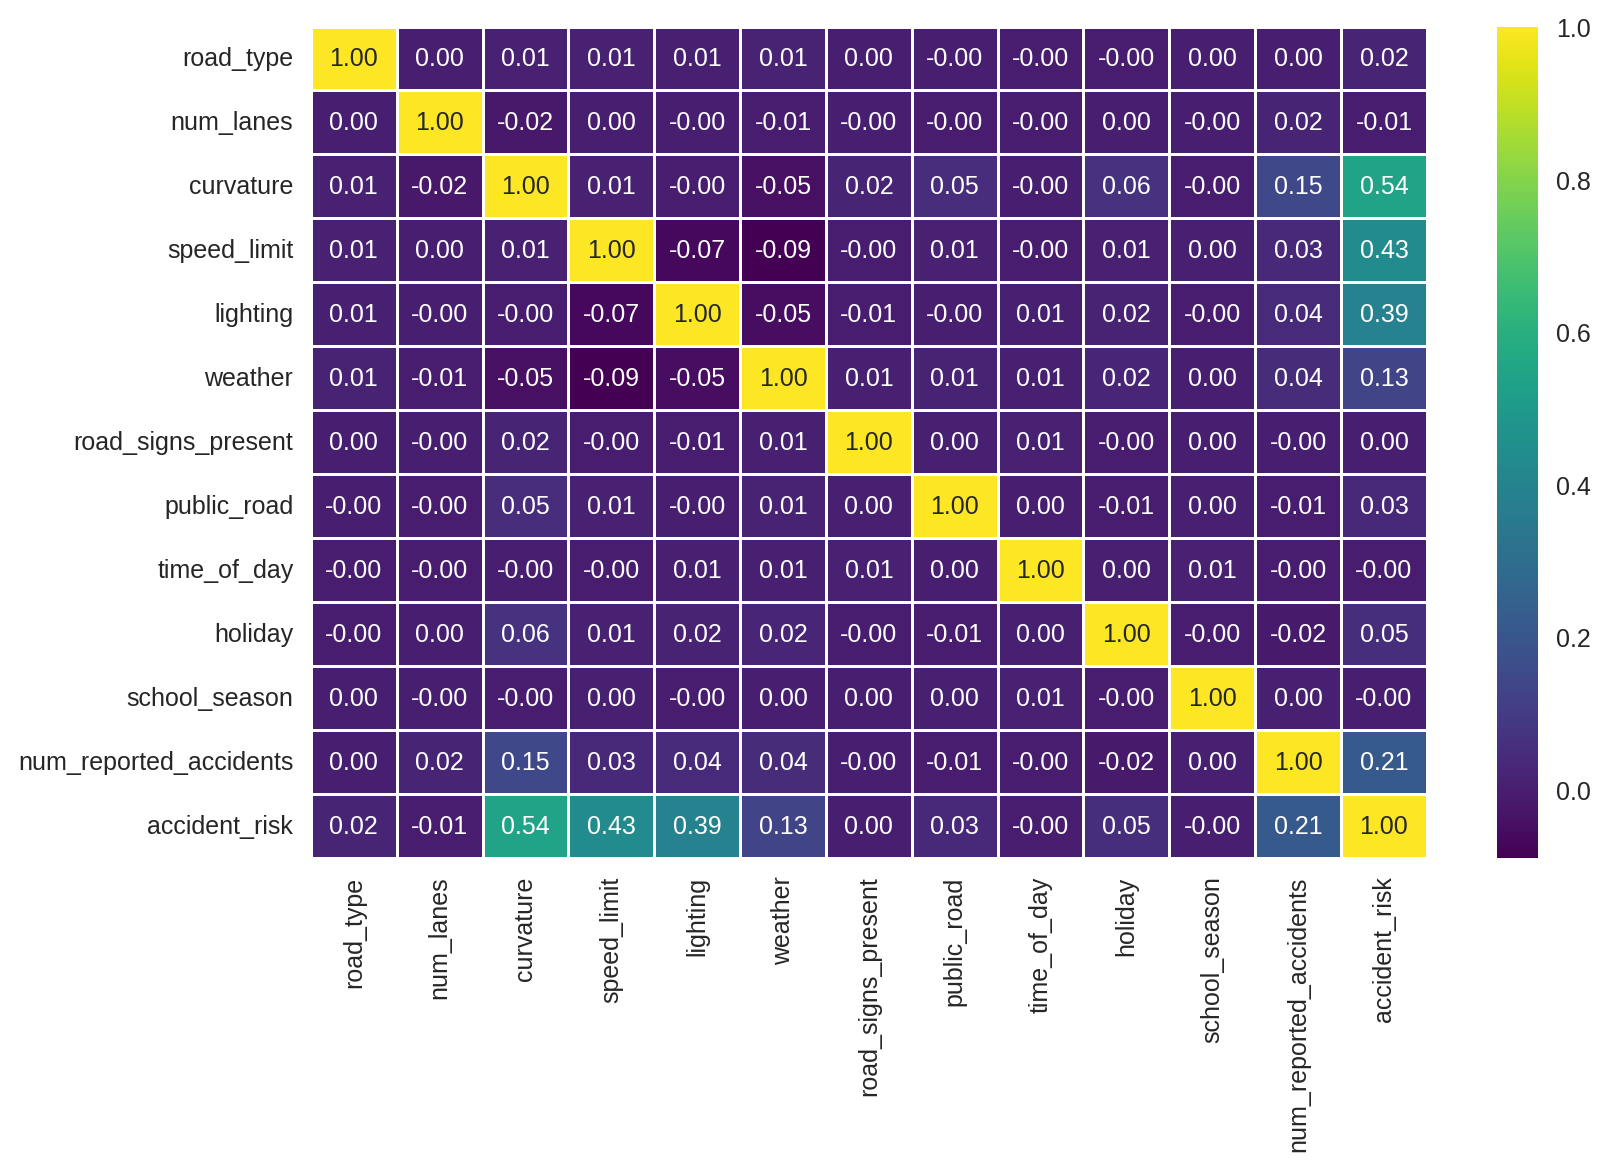

In [4]:
plt.figure(figsize=(10, 6))
sns.heatmap(train.corr(), annot=True, fmt='.2f', cmap='viridis', linewidths=1)

# Target Transformation

Text(0, 0.5, 'Frequency')

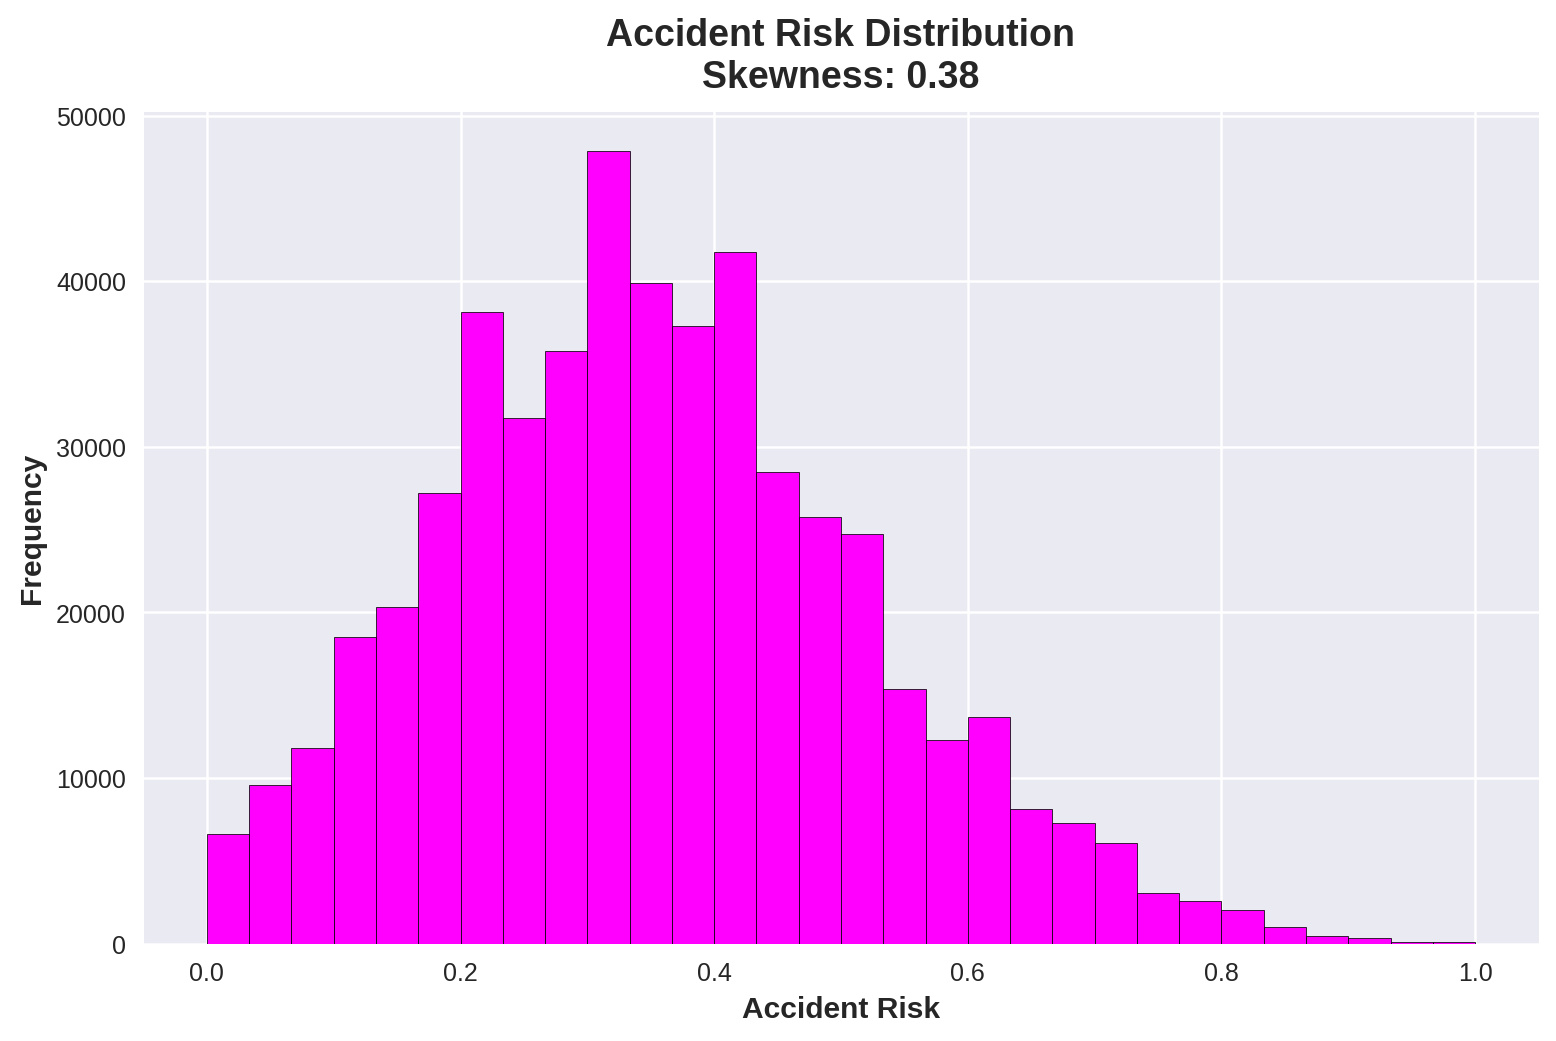

In [5]:
target = train['accident_risk']
plt.hist(target, bins=30, color='magenta', edgecolor='black')
plt.title(f'Accident Risk Distribution\nSkewness: {skew(target):.2f}')
plt.xlabel('Accident Risk')
plt.ylabel('Frequency')

#### As we can view from the histplot that the distribution of accident risk data is rightly-skewed.


## Let's transform that target values using log function to see whether the distribution is normal or not

Text(0, 0.5, 'Frequency')

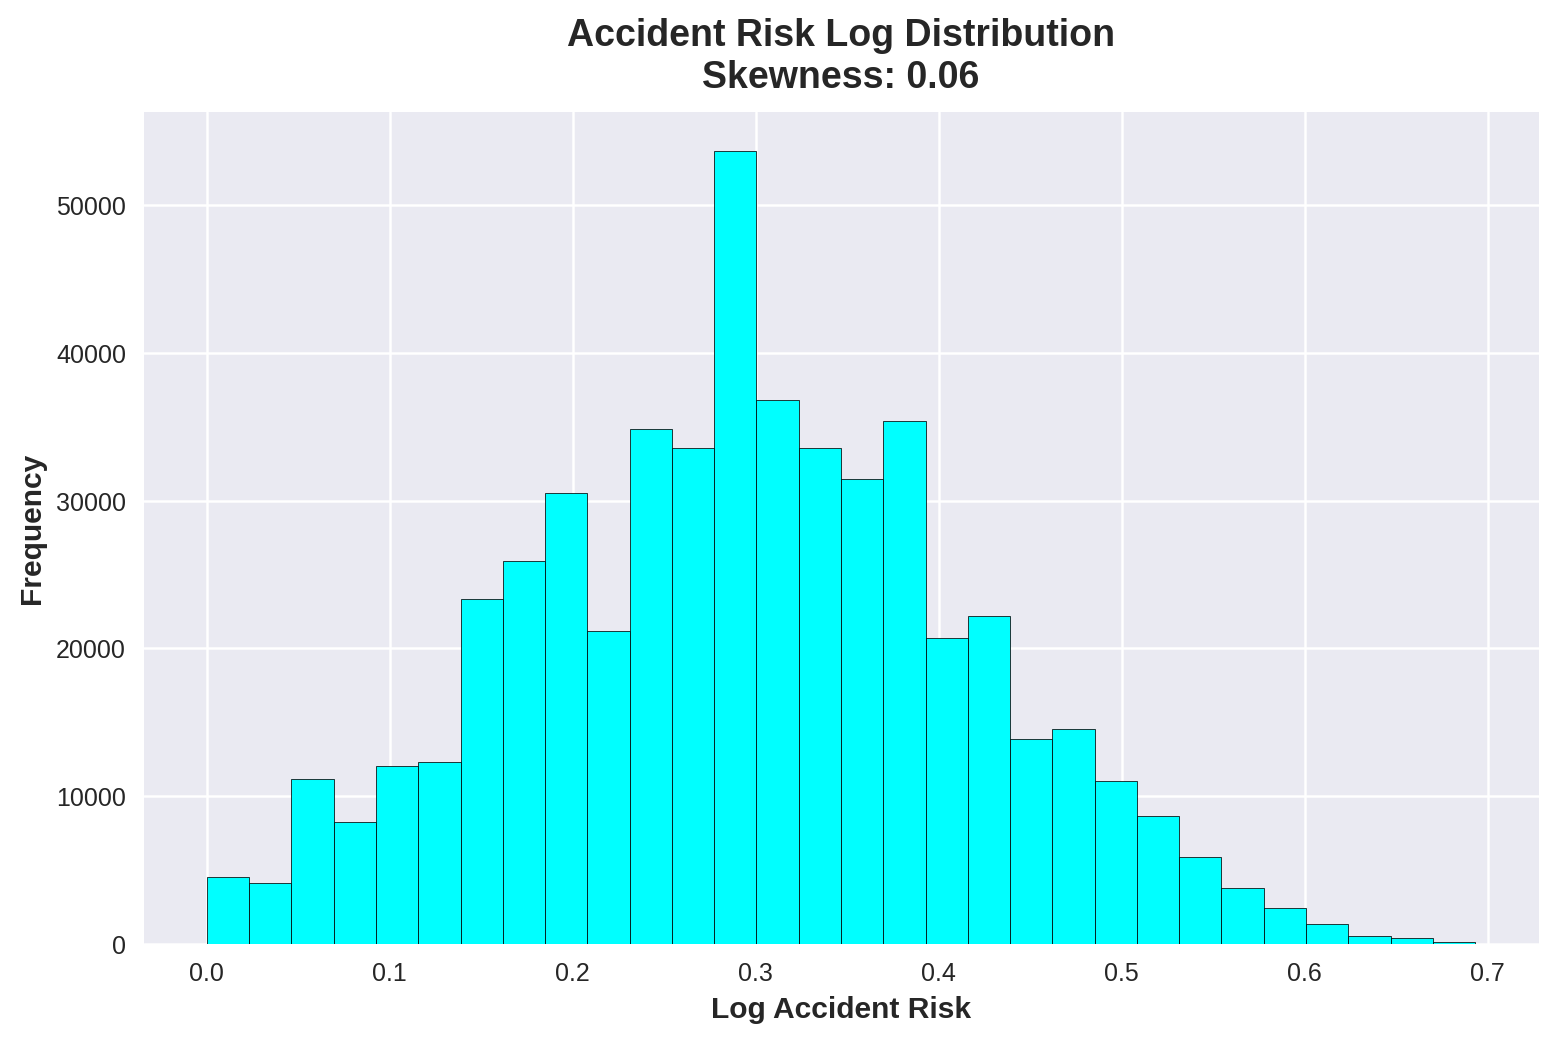

In [6]:
target_log = np.log1p(train['accident_risk'])
plt.hist(target_log, bins=30, color='cyan', edgecolor='black')
plt.title(f'Accident Risk Log Distribution\nSkewness: {skew(target_log):.2f}')
plt.xlabel('Log Accident Risk')
plt.ylabel('Frequency')

#### We can see that skewness dropped to 0.06, which is impressive and the distribution plot looks fairly normal.

## Let's try sqrt transformation

Text(0, 0.5, 'Frequency')

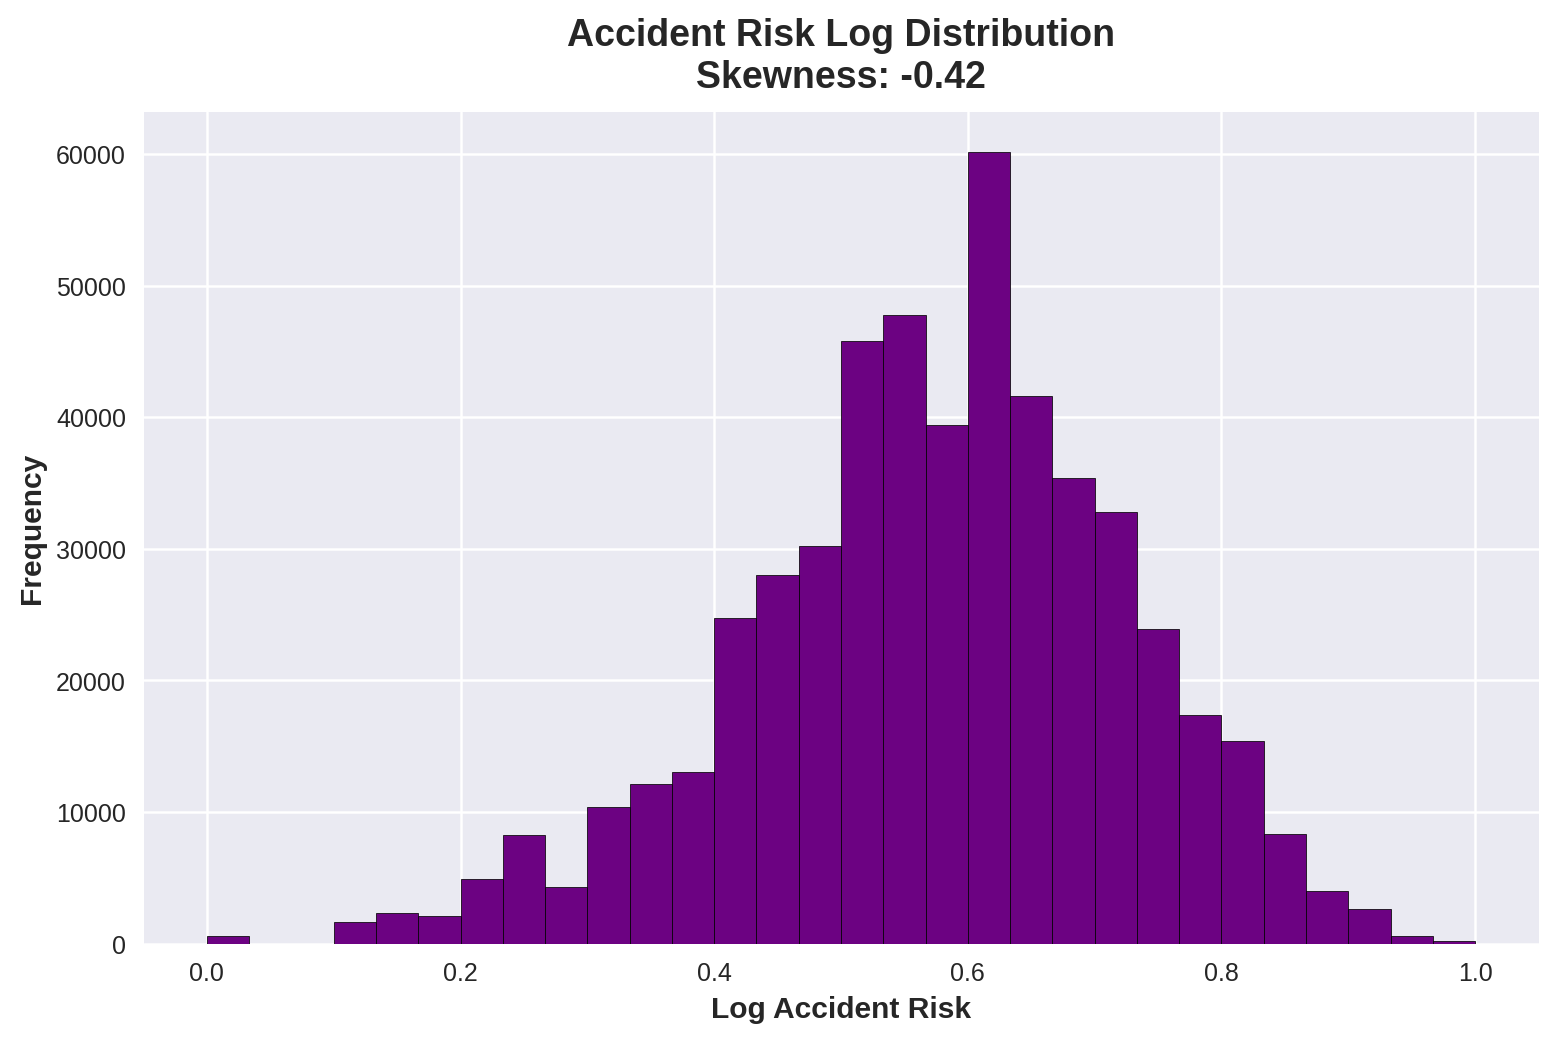

In [7]:
target_sqrt = np.sqrt(train['accident_risk'])
plt.hist(target_sqrt, bins=30, color='#6C0282', edgecolor='black')
plt.title(f'Accident Risk Log Distribution\nSkewness: {skew(target_sqrt):.2f}')
plt.xlabel('Log Accident Risk')
plt.ylabel('Frequency')

#### Sqrt transformation deemed to be ineffective since the data distribution skewed toward left and skewness is -0.42 now. So from the plots above, log transformation would be an ideal choice.

## Splitting the data into training and testing sets
- Use log transformation on the target variable

In [8]:
X = train.copy()
y = X.pop('accident_risk')
y = np.log1p(y)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=2)

### Model fitting and prediction
Let's fit a random forest regression model to the data and use it to make accident risk predicions.
Use the default parameters, which includes using 100 base estimators, or regression trees.

In [9]:
rfr = RandomForestRegressor(random_state=2, n_jobs=-1).fit(X_train, y_train)
yhat = rfr.predict(X_valid)

In [10]:
mae = mean_absolute_error(np.expm1(y_valid), np.expm1(yhat))
mse = mean_squared_error(np.expm1(y_valid), np.expm1(yhat))
rmse = np.sqrt(mean_squared_error(np.expm1(y_valid), np.expm1(yhat)))
r2score = r2_score(np.expm1(y_valid), np.expm1(yhat))

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2score:.4f}")

Mean Absolute Error (MAE): 0.0461
Mean Squared Error (MSE): 0.0035
Root Mean Squared Error (RMSE): 0.0594
R² Score: 0.8725


### Plot Actual vs Predicted values

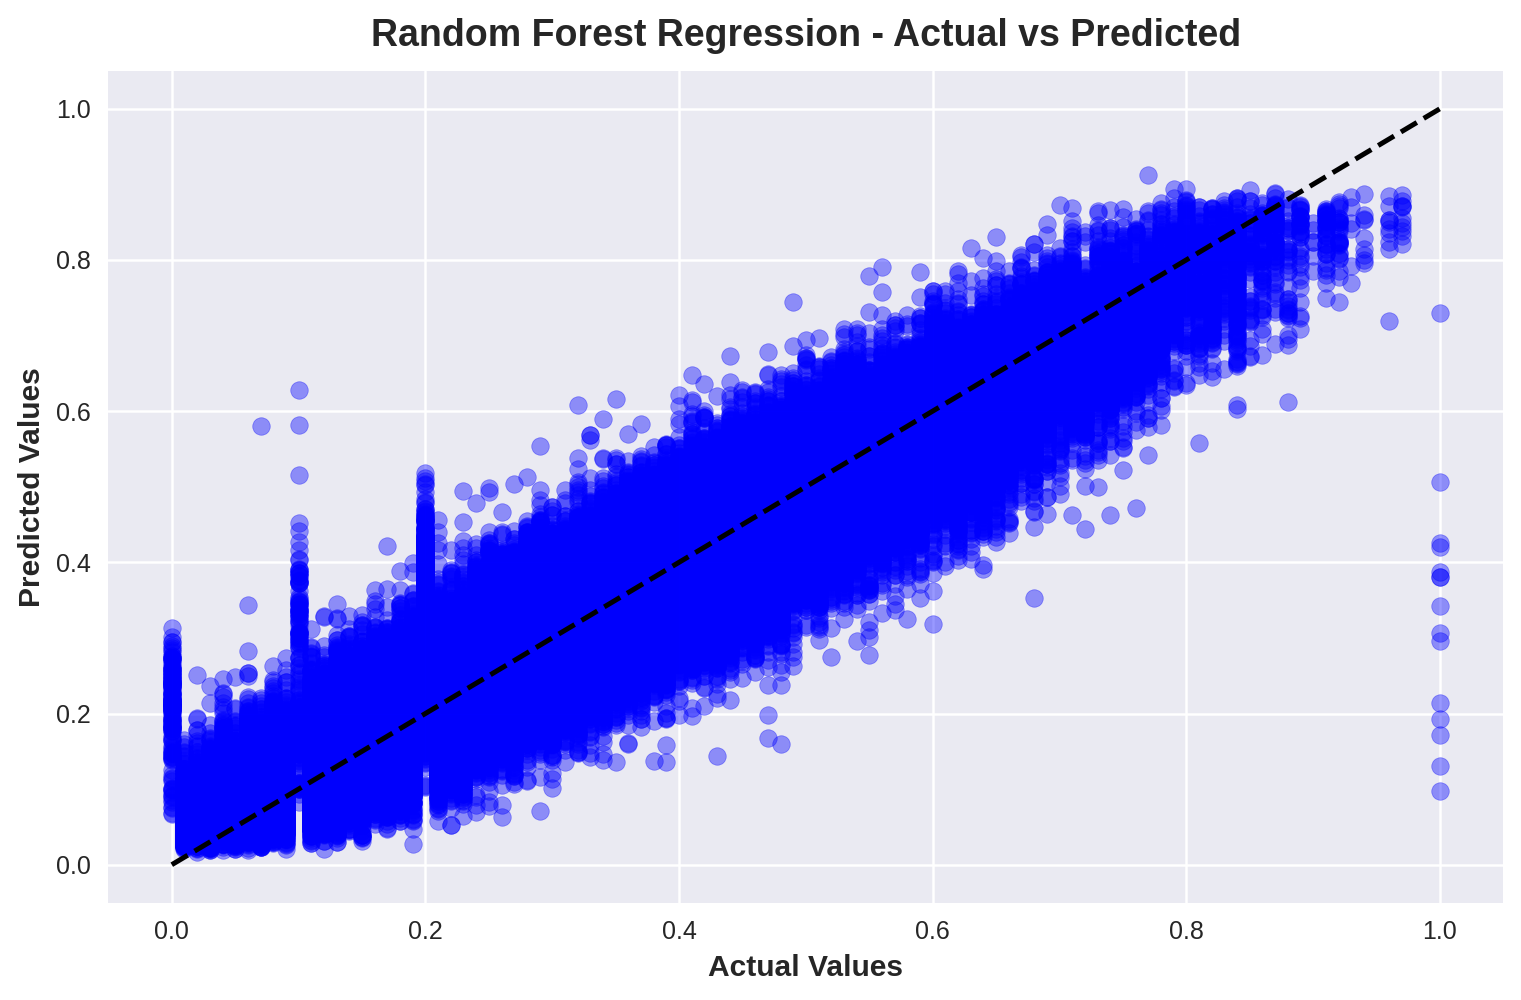

In [11]:
plt.scatter(np.expm1(y_valid), np.expm1(yhat), alpha=0.4, color='blue')
plt.plot([np.expm1(y_valid).min(), np.expm1(y_valid).max()], [np.expm1(y_valid).min(), np.expm1(y_valid).max()], 'k--', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Random Forest Regression - Actual vs Predicted")
plt.show()

Average error = 181
Standard deviation of error = 5935


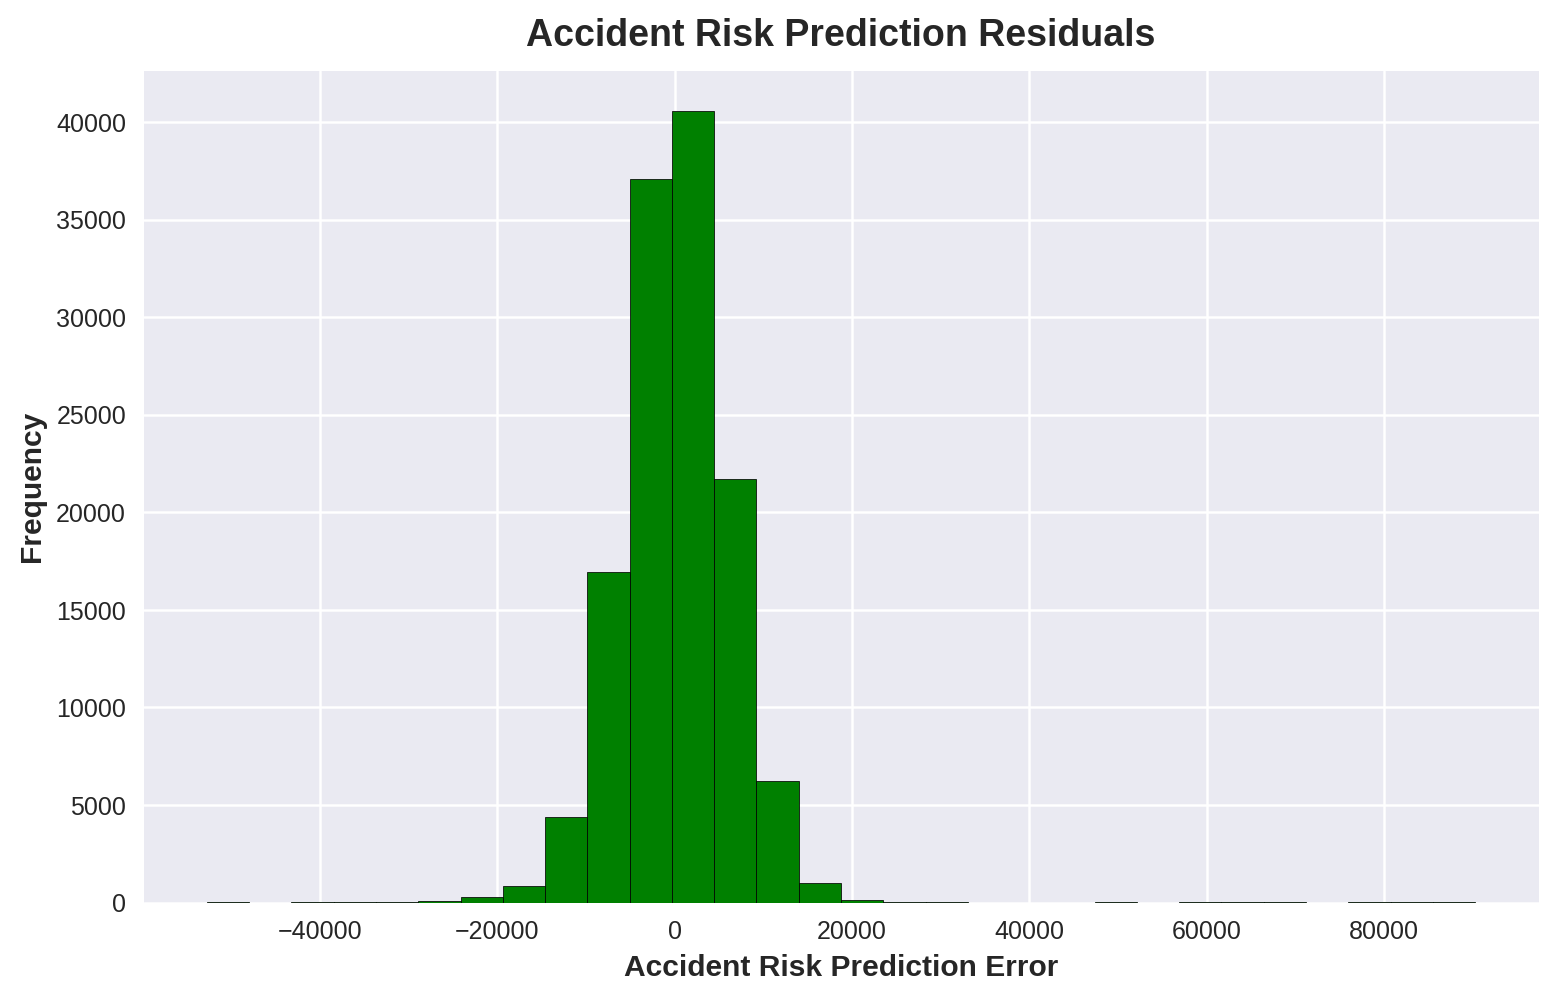

In [12]:
residuals = 1e5*(np.expm1(y_valid) - np.expm1(yhat))

# Plot the histogram of the residuals
plt.hist(residuals, bins=30, color='green', edgecolor='black')
plt.title(f'Accident Risk Prediction Residuals')
plt.xlabel('Accident Risk Prediction Error')
plt.ylabel('Frequency')
print('Average error = ' + str(int(np.mean(residuals))))
print('Standard deviation of error = ' + str(int(np.std(residuals))))

The residuals are normally distributed with a small average error of 181 and a standard deviation of 5935.

## Display the feature importances as a bar chart

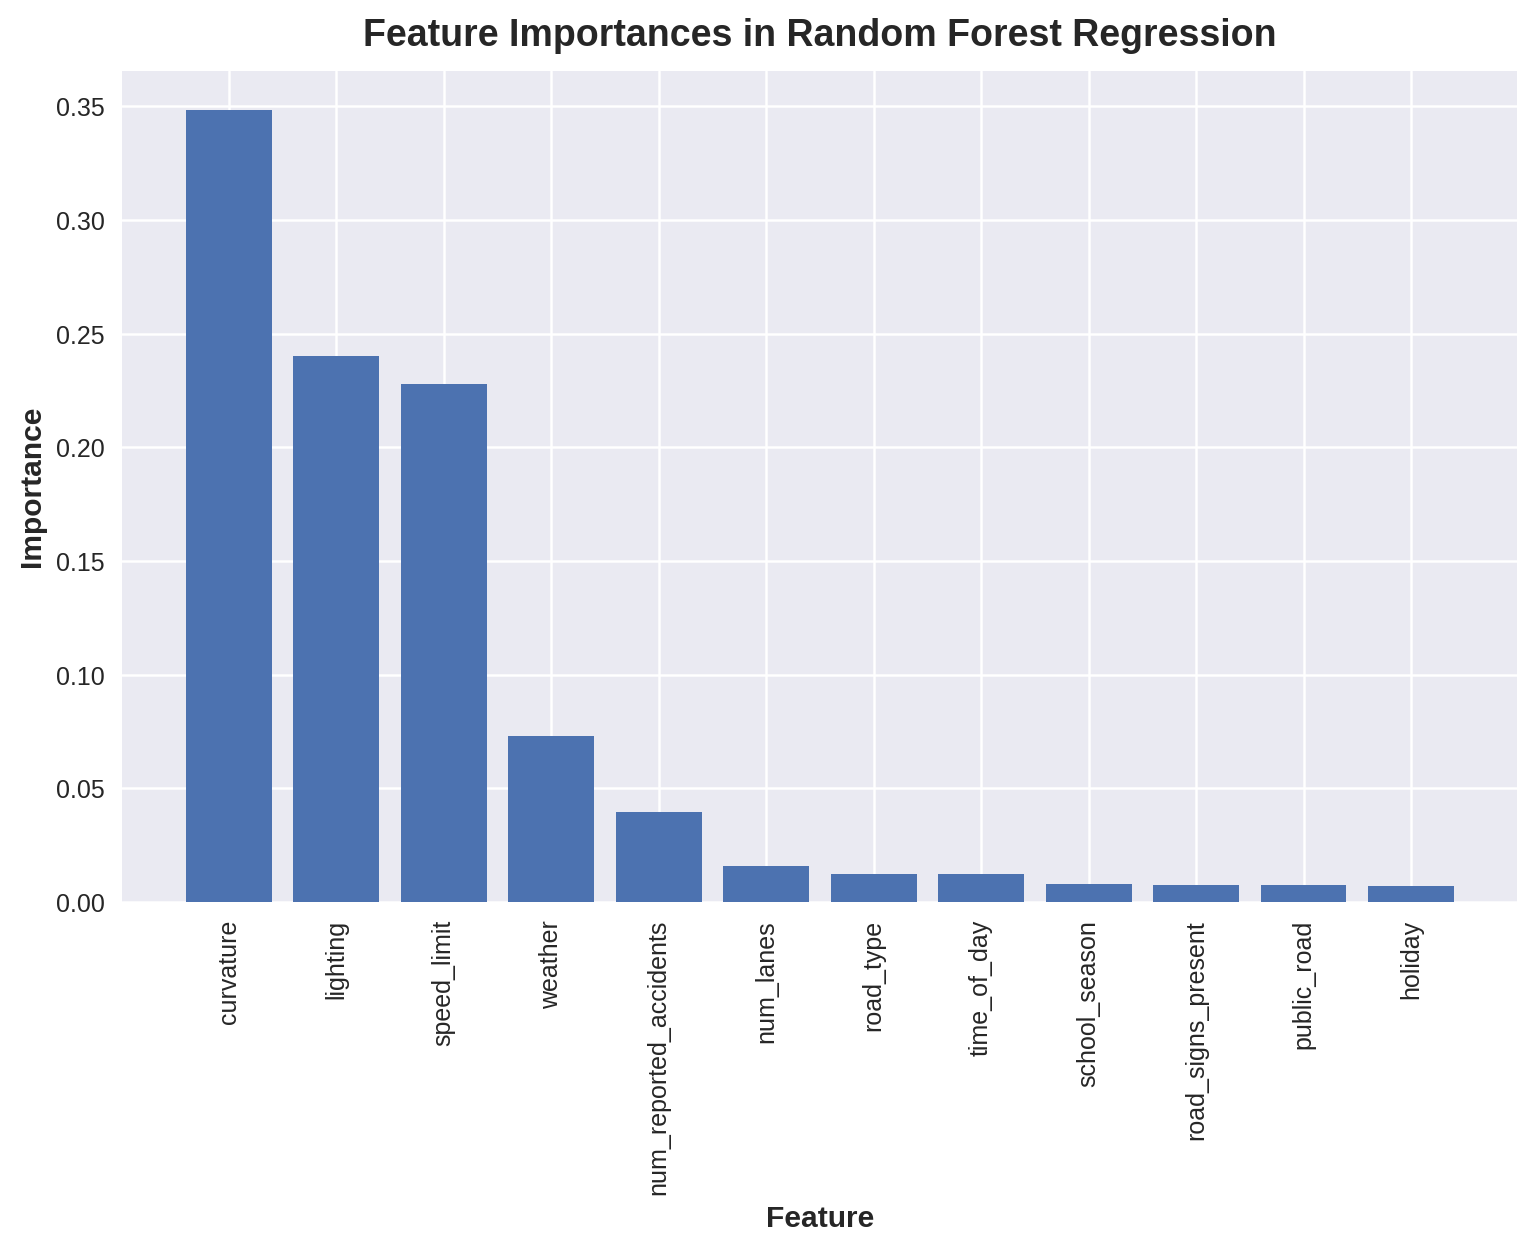

In [13]:
importances = rfr.feature_importances_
indices = np.argsort(importances)[::-1]
features = train.columns

plt.bar(range(X.shape[1]), importances[indices],  align="center")
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=45)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importances in Random Forest Regression")
plt.xticks(rotation=90)
plt.show()

In [14]:
X_test = test.copy()
preds = rfr.predict(X_test)
test_preds  = np.expm1(preds)

In [15]:
sub = pd.read_csv('/kaggle/input/playground-series-s5e10/sample_submission.csv')
sub['accident_risk'] = test_preds
sub.to_csv('submission.csv', index=False)
sub.head()

,id,accident_risk
0,517754,0.343867
1,517755,0.121889
2,517756,0.152626
3,517757,0.316416
4,517758,0.403906
